# Collaborative filtering
Name: Ibrahim Sahin
Student ID: 408846


Allereerst zullen we de benodige data inladen

In [1]:
from IPython.core.display import HTML
from movie_display import movie_display
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Load movies into a dataframe
df = pd.read_json('./dataset/imdbdata.json', orient='columns')
df_ratings = pd.read_csv('./dataset/ratings.csv')
df_movies = pd.read_csv('./dataset/movies.csv')
df_links = pd.read_csv('./dataset/links.csv')


In [2]:
df_ratings

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


Na het inladen van de data kunnen we een inzicht nemen in de data.

### Hoe vaak een film is beoordeeld.

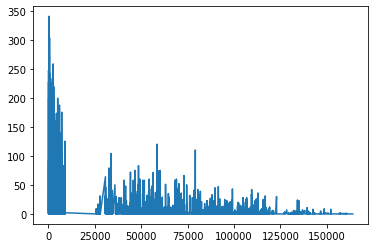

In [3]:
# how often a movie is rated
result = df_ratings.groupby(by='movieId')
data = result.size()
plt.plot(data)

### Hoe vaak een specifieke rating is gegeven.

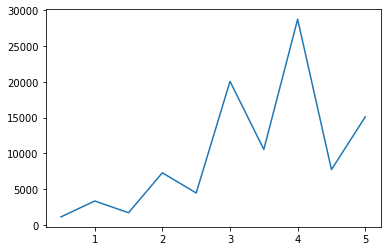

In [4]:
# how often a specific ratings is given
result = df_ratings.groupby(by='rating')
data = result.size()
plt.plot(data)

### Verdeeldheid van de gemiddelde beoordeling van een film.

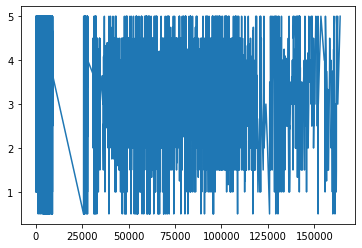

In [5]:
# Distribution of the average ratings given to a movie
result = df_ratings.groupby(by='movieId').agg({'rating' : 'mean'})
plt.plot(result)

### Verdeeldheid van de gemiddelde beoordeling gegeven door een gebruiker

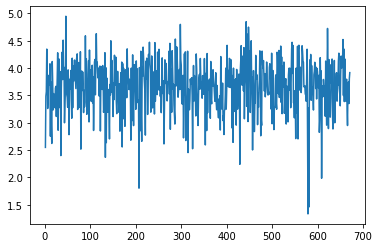

In [6]:
# Distribution of the average ratings given by a user
result = df_ratings.groupby(by='userId').agg({'rating' : 'mean'})
plt.plot(result)

## Dataset analysis

Voordat we verder gaan zullen we een analyse uitvoeren op de movie dataset.

In [7]:
df_ratings.describe(include="all")

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


De minimale rating is een 0.5 en de maximale rating is een 5.0. Er lijken dus geen rare outliers te zijn die buiten de 0.5 - 5.0 range zitten.

In [8]:
df_ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Op dit moment lijken er geen problemen te zijn met de dataset van de ratings

In [9]:
df_movies.describe(include="all")

,movieId,title,genres
count,9125.000000,9125,9125
unique,NaN,9123,902
top,NaN,War of the Worlds (2005),Drama
freq,NaN,2,1170
mean,31123.291836,NaN,NaN
std,40782.633604,NaN,NaN
min,1.000000,NaN,NaN
25%,2850.000000,NaN,NaN
50%,6290.000000,NaN,NaN
75%,56274.000000,NaN,NaN


Kijkend naar de resultaten, lijkt het erop dat er een duplicatie zit in film titels. Deze duplicatie zullen we verwijderen. De duplicatie van genre kunnen we negeren, omdat het logisch is omdat er films bestaan die dezelfde genres hebben.

In [10]:
# there seems to be some duplicates on the titel.
df_movies.drop_duplicates(subset='title', inplace=True)
#duplicates removed.

De duplicaten zijn verwijderd. Verder lijken er ook geen null waardes te zijn. Dus kunnen we verder met het samenvoegen van de data tot 1 matrix

In [11]:
ratings = df_ratings
movies = df_movies

ratings

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


De ratings dataset bevat een movieId. De MovieId kan gebruikt worden om de ratings dataset te mergen met de movie dataset.

In [12]:
df_test = pd.merge(ratings, movies, on='movieId', how='left')
df_test
df_test.head(10)

,userId,movieId,rating,timestamp,title,genres
0,1,31,2.5,1260759144,Dangerous Minds (1995),Drama
1,1,1029,3.0,1260759179,Dumbo (1941),Animation|Children|Drama|Musical
2,1,1061,3.0,1260759182,Sleepers (1996),Thriller
3,1,1129,2.0,1260759185,Escape from New York (1981),Action|Adventure|Sci-Fi|Thriller
4,1,1172,4.0,1260759205,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama
5,1,1263,2.0,1260759151,"Deer Hunter, The (1978)",Drama|War
6,1,1287,2.0,1260759187,Ben-Hur (1959),Action|Adventure|Drama
7,1,1293,2.0,1260759148,Gandhi (1982),Drama
8,1,1339,3.5,1260759125,Dracula (Bram Stoker's Dracula) (1992),Fantasy|Horror|Romance|Thriller
9,1,1343,2.0,1260759131,Cape Fear (1991),Thriller


Zoals het hierboven te zien is, zijn de twee datasets samengevoegd. Nu zullen we verder gaan met het analyseren van de data.

### Gemiddelde beoordeling van een film

In [13]:
average_ratings = pd.DataFrame(df_test.groupby('title')['rating'].mean())
average_ratings.head(10)

,rating
title,
"""Great Performances"" Cats (1998)",1.750000
$9.99 (2008),3.833333
'Hellboy': The Seeds of Creation (2004),2.000000
'Neath the Arizona Skies (1934),0.500000
'Round Midnight (1986),2.250000
'Salem's Lot (2004),3.500000
'Til There Was You (1997),2.625000
"'burbs, The (1989)",3.052632
'night Mother (1986),5.000000


### Totaal aantal beoordelingen van een film

In [14]:
average_ratings['Total Ratings'] = pd.DataFrame(df_test.groupby('title')['rating'].count())
average_ratings.head(10)

,rating,Total Ratings
title,,
"""Great Performances"" Cats (1998)",1.750000,2
$9.99 (2008),3.833333,3
'Hellboy': The Seeds of Creation (2004),2.000000,1
'Neath the Arizona Skies (1934),0.500000,1
'Round Midnight (1986),2.250000,2
'Salem's Lot (2004),3.500000,1
'Til There Was You (1997),2.625000,4
"'burbs, The (1989)",3.052632,19
'night Mother (1986),5.000000,3


Na het analyseren zullen we nu verder gaan met het toepassen van Collaborative Filtering. Allereerst zullen we bezig gaan met een Movie -> User matrix.

## Movie -> User matrix

Items die niet beoordeeld zijn door een gebruiker zullen gevuld worden met 0. De reden hiervoor is dat de cosine similarity functie niet om kan gaan met NaN waardes.

In [15]:
movie_user = df_test.pivot_table(index='userId', columns='title', values='rating')
movie_user.head(10)
movie_user = movie_user.fillna(0)
movie_user

title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),...,Zulu (1964),Zulu (2013),[REC] (2007),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),İtirazım Var (2014)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Voor ieder Recommendation onderdeel zullen we de volgende Similarity Metrics gebruiken:

- Cosine Similarity
- Pearson Similarity
- Adjusted Cosine Similarity

Hieronder zullen we ieder metric definieren en testen door middel van een voorbeeld dataset. 

De voorbeeld dataset ziet er als volgt uit met een x aantal films en 3 gebruikers(0, 1, 2).

In [16]:
test_example_array = [[4,0,0,5,1,0,0],[5,5,4,0,0,0,0],[0,0,0,2,4,5,0]]
test_example_df = pd.DataFrame(data=test_example_array)
test_example_df

,0,1,2,3,4,5,6
0,4,0,0,5,1,0,0
1,5,5,4,0,0,0,0
2,0,0,0,2,4,5,0


### Cosine Similarity

Hieronder zullen we de Cosine similarity functie definieren.

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine_similarity_metric(input_df, amount_of_users):
    user_user = pd.DataFrame( np.empty((amount_of_users, amount_of_users)))
    
    for i in range(0, amount_of_users):
        userA = input_df.iloc[i]
    
        for ii in range(0,amount_of_users):
            userB = input_df.iloc[ii]
            similarity = 0
            similarity = cosine_similarity(userA.to_numpy().reshape(1, -1), userB.to_numpy().reshape(1, -1))
            user_user.at[i, ii] = similarity
        print('user: ', i, ' is done.')
        
    return user_user

Om de metric te testen hebben we een kleine dataset aangemaakt met 3 gebruikers en de bijbehorende beoordelingen. Op deze dataset willen we de hierboven gedefinieerde cosine metric op toepassen. 

#### Test cosine similarity with dataset

In [18]:
results_cosine_similarity_test = cosine_similarity_metric(test_example_df, len(test_example_df))
results_cosine_similarity_test

user:  0  is done.
user:  1  is done.
user:  2  is done.


,0,1,2
0,1.000000,0.379869,0.322031
1,0.379869,1.000000,0.000000
2,0.322031,0.000000,1.000000


We hebben nu de cosine similarity metric op de dataset uitgevoerd. Hierboven zijn de resultaten te zien. Hierin geven we de cosine similarity tussen de gebruikers weer. Hoe meer de waarde dichter bij de 1 des te meer overeenkomsten er zijn. Hoe meer de waarde bij de 0, des te minder dus.

Na het toepassen van de metric zien we de resultaten hierboven. Daaruit kunnen we de volgende conclusies trekken:

- Gebruiker 0 -> gebruiker 1 hebben een similarity van 0.38 afgerond.
- gebruiker 0 -> gebruiker 2 hebben een similarity van 0.32 afgerond.
- gebruiker 0 -> gebruiker 1 hebben een similarity van 0.00.
- gebruiker 0 -> gebruiker 1 hebben meer overeenkomsten samen dan gebruiker 0 -> gebruiker 2 en gebruiker 1 -> gebruiker 2

Nu zullen we zelf de similarity metric met de hand berekenen. De formule hiervoor is 

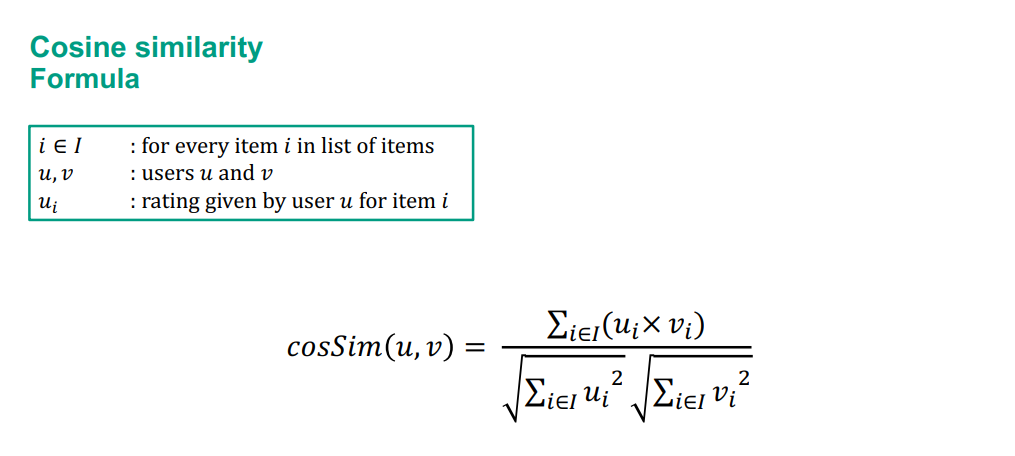

#### Test 1
Dit betekent voor het berekenem van de similarity tussen gebruiker 0 en 1 het volgende:

Cosine similarity(0, 1) = <br>
(4x5+0x5+0x4+5x0+1x0+0x0+0x0) / √(4²+0+0+5²+1²+0+0) x √(5²+5²+4²+0+0+0+0) = <br>
20 / (√42 x √66) = <br>
20 / 52,65 = <br>
0.38 

#### Test 2
Dit betekent voor het berekenem van de similarity tussen gebruiker 0 en 2 het volgende:

Cosine similarity(0, 2) = <br>
(4x0+0x0+0x0+5x2+1x4+0x5+0x0) / √(4²+0+0+5²+1²+0+0) x √(0+0+0+2²+4²+5²+0) = <br>
14 / (√42 x √45) = <br>
14 / 43.47 = <br>
0.32

De resultaten uit de testen komen overeen met de resultaten uit de gedefinieerde metric. Dit betekent dat de gedefinieerde cosine similarity metric goed lijkt te werken.

### Pearson similarity

Hieronder zullen we de Pearson similarity functie definieren.

In [24]:
def getAverage(row):
    total = row.sum()
    ratedMovies = 0
    for i in range(0, len(row) - 1):
        if row.iloc[i] > 0:
            ratedMovies = ratedMovies + 1
    
    if ratedMovies == 0:
        return 0
    return total/ratedMovies

def pearson(row):
    for i in range(0, len(row) - 1):
        if row[i] > 0:
            row[i] = row[i] - row['mean']
    return row

def pearson_similarity_metric(input_df):
    input_df_copy = input_df.copy(deep=True)
    input_df_copy['mean'] = input_df_copy.apply(lambda row : getAverage(row), axis=1)
    input_df_copy = input_df_copy.apply(lambda row : pearson(row), axis=1)
    return input_df_copy

def pearson_cosine_similarity_metric(input_df):
    result_pearson_metric = pearson_similarity_metric(input_df)
    result_pearson_metric.drop('mean', inplace=True, axis=1)
    result_cosine_similarity = cosine_similarity_metric(result_pearson_metric, len(result_pearson_metric))
    return result_cosine_similarity

Om de metric te testen hebben we een kleine dataset aangemaakt met 3 gebruikers en de bijbehorende beoordelingen. Op deze dataset willen we de hierboven gedefinieerde pearson metric op toepassen. 

### Test pearson similarity with dataset

Allereerst zullen we testen of de functie voor het normalizeren van de vectors werkt. Het normalizeren van de vectors zorgt ervoor dat de ratings rond 0 zijn gecentreerd.

#### Test normalisatie vectors

In [25]:
result_pearson_similarity_metric_test = pearson_similarity_metric(test_example_df)
result_pearson_similarity_metric_test

,0,1,2,3,4,5,6,mean
0,0.666667,0.000000,0.000000,1.666667,-2.333333,0.000000,0.0,3.333333
1,0.333333,0.333333,-0.666667,0.000000,0.000000,0.000000,0.0,4.666667
2,0.000000,0.000000,0.000000,-1.666667,0.333333,1.333333,0.0,3.666667


We hebben nu het normaliseren van de vectors op de dataset uitgevoerd. Hierboven zijn de resultaten te zien. Hierin geven we de ratings genormaliseerd weer. positieve waardes representeren positieve ratings en negatiefe waardes representeren negatieve ratings.

Nu zullen we de normalisatie met de hand berekenen

#### Test 1

Hiervoor zullen we eerst de gemiddelde rating berekenen van gebruiker 0.

Gem van gebruiker 0 = <br>
(4 + 5 + 1) / 3 = <br>
10 / 3

Na het berekenen van de gemiddelde zullen we de gemiddelde aftrekken van de ratings.
4 - 10/3 = 2/3
5 - 10/3 = 5/3
1 - 10/3 = -7/3

Dit levert de volgende lijst van ratings op voor gebruiker 0:

[2/3, 0, 0, 5/3, -7/3, 0, 0]

#### Test 2

Hiervoor zullen we eerst de gemiddelde rating berekenen van gebruiker 1.

Gem van gebruiker 0 = <br>
(5 + 5 + 4) / 3 = <br>
14 / 3

Na het berekenen van de gemiddelde zullen we de gemiddelde aftrekken van de ratings.
5 - 14/3 = 1/3
5 - 14/3 = 1/3
4 - 14/3 = -2/3

Dit levert de volgende lijst van ratings op voor gebruiker 0:

[1/3, 1/3, -2/3, 0, 0, 0, 0]

#### Conclusie
De resultaten van beide tests komen overeen met de resultaten van de functies. hieruit kunnen we concluderen dat het normaliseren van de vectors werkt.

### Test Pearson correlation metric

In [26]:
result_pearson_cosine_similarity_test = pearson_cosine_similarity_metric(test_example_df)
result_pearson_cosine_similarity_test

user:  0  is done.
user:  1  is done.
user:  2  is done.


,0,1,2
0,1.000000,0.09245,-0.559085
1,0.092450,1.00000,0.000000
2,-0.559085,0.00000,1.000000


We hebben nu pearson similarity metric op de dataset uitgevoerd. Hierboven zijn de resultaten te zien. Hierin geven we de cosine similarity tussen de gebruikers weer. Hoe meer de waarde dichter bij de 1 des te meer overeenkomsten er zijn. Hoe meer de waarde bij de 0, des te minder dus.

Na het toepassen van de metric zien we de resultaten hierboven. Daaruit kunnen we de volgende conclusies trekken:

- Gebruiker 0 -> gebruiker 1 hebben een similarity van 0.38 afgerond.
- gebruiker 0 -> gebruiker 2 hebben een similarity van 0.32 afgerond.
- gebruiker 0 -> gebruiker 1 hebben een similarity van 0.00.
- gebruiker 0 -> gebruiker 1 hebben meer overeenkomsten samen dan gebruiker 0 -> gebruiker 2 en - - gebruiker 1 -> gebruiker 2

Nu zullen we zelf de similarity metric met de hand berekenen. De formule hiervoor is

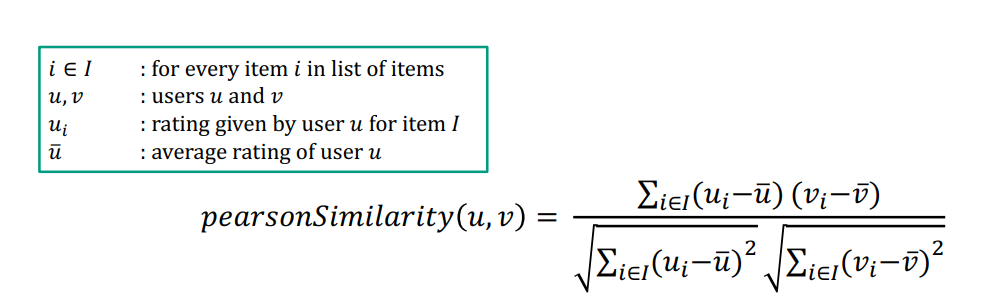

#### Test 1

Hiervoor zullen we de lijst die in Test 1 en 2 zijn berekend gebruiken.

genormaliseerde ratings gebruiker 0 = [2/3, 0, 0, 5/3, -7/3, 0, 0]
genormaliseerde ratings gebruiker 1 = [1/3, 1/3, -2/3, 0, 0, 0, 0]

Dit betekent voor het berekenem van de similarity tussen gebruiker 0 en 1 het volgende:



Pearson Similarity(0,1) =

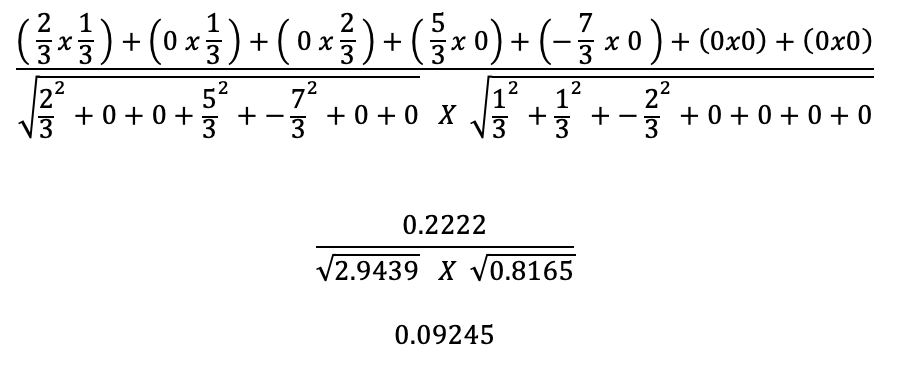

De resultaat uit de test komen overeen met de resultaat uit de gedefinieerde metric. Dit betekent dat de gedefinieerde pearson similarity metric goed lijkt te werken.


#### Conclusie
Het resultaat van de test komt overeen met de resultaten van de functies. hieruit kunnen we concluderen dat de gedefinieerde pearson similarity metric werkt.

## Adjusted Cosine similarity

Hieronder zullen we de Adjusted Sosine similarity functie definieren.

In [52]:
def getAverageColumn(col):
    total = col.sum()

    ratedMovies = 0
    for i in range(0, len(col)):
        if col.iloc[i] > 0:
            ratedMovies = ratedMovies + 1
    
    if ratedMovies == 0:
        return 0
    return total/ratedMovies

def adjusted_cosine_normalizing(col):
    for i in range(0, len(col)-1):
        if col[i] > 0:
            col[i] = col[i] - col['mean']
    return col

def adjustud_cosine_metric(input_df):
    input_df_copy = input_df.copy(deep=True)
    mean_row = input_df_copy.apply(lambda col : getAverageColumn(col))
    mean_df = pd.DataFrame([mean_row], index = ["mean"])
    input_df_with_mean = pd.concat([mean_df, input_df_copy])
    input_df_with_mean = input_df_with_mean.apply(lambda col : adjusted_cosine_normalizing(col))
    return input_df_with_mean

def adjusted_cosine_similarity_metric(input_df):
    result_adjusted_cosine_metric = adjustud_cosine_metric(input_df)
    result_adjusted_cosine_metric.drop('mean', inplace=True)
    result_adjusted_cosine_similarity = cosine_similarity_metric(result_adjusted_cosine_metric, len(result_adjusted_cosine_metric))
    return result_adjusted_cosine_similarity

test_example_array2 = [[4,0,0,5,1,0,0],[5,5,4,0,0,0,0],[0,0,0,2,4,5,0],[0,3,0,0,0,0,3]]
test_example_df2 = pd.DataFrame(data=test_example_array2)
test_example_df2

,0,1,2,3,4,5,6
0,4,0,0,5,1,0,0
1,5,5,4,0,0,0,0
2,0,0,0,2,4,5,0
3,0,3,0,0,0,0,3


Om de metric te testen hebben we een kleine dataset aangemaakt met 4 gebruikers en de bijbehorende beoordelingen. Op deze dataset willen we de hierboven gedefinieerde adjusted cosine similarity metric op toepassen. 

### Test adjusted cosine similarity with dataset

Allereerst zullen we testen of de functie voor het normaliseren van de vectors werkt. Het normaliseren van de vectors zorgt ervoor dat de ratings rond 0 zijn gecentreerd.

#### Test normalisatie vectors

In [53]:
result_cosine_metric = adjustud_cosine_metric(test_example_df2)
result_cosine_metric

,0,1,2,3,4,5,6
mean,4.5,4.0,4.0,3.5,2.5,5.0,3.0
0,-0.5,0.0,0.0,1.5,-1.5,0.0,0.0
1,0.5,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,-1.5,1.5,0.0,0.0
3,0.0,-1.0,0.0,0.0,0.0,0.0,0.0


We hebben nu het normaliseren van de vectors op de dataset uitgevoerd. Hierboven zijn de resultaten te zien. Hierin geven we de ratings genormaliseerd weer. positieve waardes representeren positieve ratings en negatiefe waardes representeren negatieve ratings.

Nu zullen we de normalisatie met de hand berekenen

#### Test 1

Hiervoor zullen we eerst de gemiddelde rating berekenen van film 0.

Gem van film 0 = <br>
(4 + 5) / 2 = <br>
9 / 2 = <br>
4.5

Na het berekenen van de gemiddelde zullen we de gemiddelde aftrekken van de ratings.
4 - 4.5 = -0.5
5 - 4.5 = 0.5

Dit levert de volgende lijst van ratings op voor film 0:

[-0.5, 0.5, 0, 0]

#### Test 2

Hiervoor zullen we eerst de gemiddelde rating berekenen van film 1.

Gem van gebruiker 0 = <br>
(5 + 3) / 2 = <br>
8 / 2 = <br>
4

Na het berekenen van de gemiddelde zullen we de gemiddelde aftrekken van de ratings.
5 - 4 = 1
3 - 4 = -1

Dit levert de volgende lijst van ratings op voor film 1:

[0, 1, 0, -1]

#### Conclusie
De resultaten van beide tests komen overeen met de resultaten van de gedefinieerde functies. hieruit kunnen we concluderen dat het normaliseren van de vectors werkt.

### Test adjsuted cosine similarity metric

In [54]:
result_adjusted_cosine_similarity = adjusted_cosine_similarity_metric(test_example_df2)
result_adjusted_cosine_similarity

user:  0  is done.
user:  1  is done.
user:  2  is done.
user:  3  is done.


,0,1,2,3
0,1.000000,-0.102598,-0.973329,0.000000
1,-0.102598,1.000000,0.000000,-0.894427
2,-0.973329,0.000000,1.000000,0.000000
3,0.000000,-0.894427,0.000000,1.000000


We hebben nu de adjusted cosine similarity metric op de dataset uitgevoerd. Hierboven zijn de resultaten te zien. Hierin geven we de cosine similarity tussen de gebruikers weer. Hoe meer de waarde dichter bij de 1 des te meer overeenkomsten er zijn. Hoe meer de waarde bij de -1, des te minder dus.

Na het toepassen van de metric zien we de resultaten hierboven. Daaruit kunnen we de volgende conclusies trekken:

- Gebruiker 0 -> gebruiker 1 hebben een similarity van 0.38 afgerond.
- gebruiker 0 -> gebruiker 2 hebben een similarity van 0.32 afgerond.
- gebruiker 0 -> gebruiker 1 hebben een similarity van 0.00.
- gebruiker 0 -> gebruiker 1 hebben meer overeenkomsten samen dan gebruiker 0 -> gebruiker 2 en - - gebruiker 1 -> gebruiker 2

Nu zullen we zelf de similarity metric met de hand berekenen. De formule hiervoor is

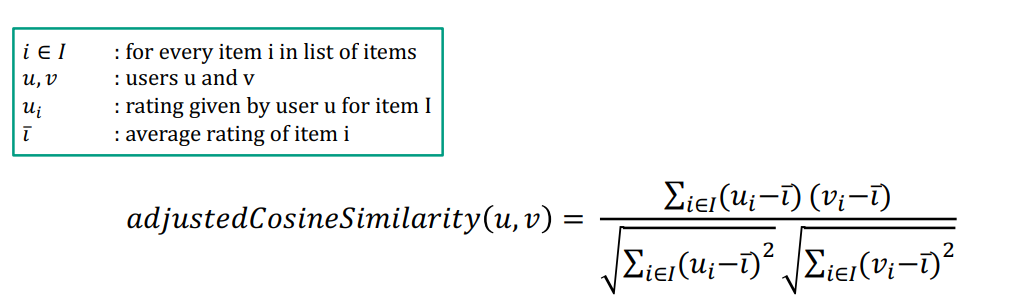

#### Test 1

Hiervoor zullen we eerst de gemiddelde rating berekenen per film en dit aftrekken van de rating van de gebruiker voor die film. Daaruit onstaat de volgende lijst 

genormaliseerde ratings gebruiker 0 = [-0.5, 0, 0, 3/2, -3/2, 0, 0] <br>
genormaliseerde ratings gebruiker 1 = [0.5, 1, 0, 0, 0, 0, 0] <br>
genormaliseerde ratings gebruiker 2 = [0, 0, 0, -3/2, 3/2, 0, 0] <br>
genormaliseerde ratings gebruiker 3 = [0, -1, 0, 0, 0, 0, 0]

Dit betekent voor het berekenen van de similarity tussen gebruiker 0 en 1 het volgende:



Adjusted Cosine Similarity(0,1) =

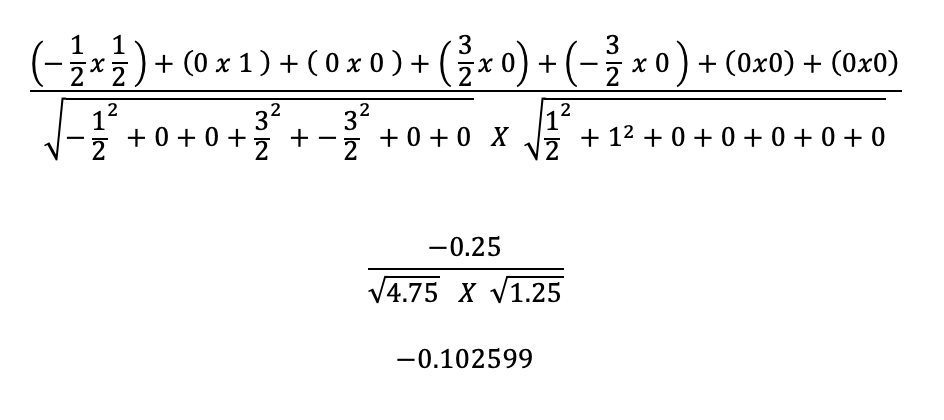

De resultaat uit de test komen overeen met de resultaat uit de gedefinieerde metric. Dit betekent dat de gedefinieerde adjusted cosine similarity metric goed lijkt te werken.


#### Conclusie
Het resultaat van de test komt overeen met de resultaten van de functies. hieruit kunnen we concluderen dat de gedefinieerde adjusted cosine similarity metric werkt.


Nu we voor ieder similarity metric een implementatie hebben geschreven en dit ook hebben getest/gevalideerd door middel van een voorbeeld kunnen we werder met het implementeren van de recommendation systems

Voor het opdracht zal er een User-User en Item-Item recommendation systeem gemaakt worden.

## User-user recommendation

## Item-item recommendation

## User-user recommendations

In [20]:
user_user_pearson = pd.DataFrame( np.empty((amount_of_users, amount_of_users)))

In [21]:
movie_user['mean'] = movie_user.mean(axis=1)
movie_user['mean']
def getAverage(row):
    total = row.sum()
    ratedMovies = 0
    for i in range(0, len(row)-1):
        if row.iloc[i] > 0:
            ratedMovies = ratedMovies + 1
    #print(ratedMovies)
    return total/ratedMovies
movie_user['mean'] = movie_user.apply(lambda row : getAverage(row), axis=1)

In [22]:
movie_user['mean']

userId
1      2.550281
2      3.487227
3      3.569021
4      4.348519
5      3.910431
         ...   
667    3.647461
668    3.750414
669    3.351721
670    3.806872
671    3.917823
Name: mean, Length: 671, dtype: float64

### Pearson Similarity

In [23]:
def pearson(row):
    for i in range(1, len(row)):
        if row[i] > 0:
            row[i] = row[i] - row['mean']
    return row
movie_user_pearson = movie_user.copy(deep=True)
movie_user_pearson = movie_user_pearson.apply(lambda row : pearson(row), axis=1)
movie_user_pearson

title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),...,Zulu (2013),[REC] (2007),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),İtirazım Var (2014),mean
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
mean_row = movie_user.apply(lambda row : getAverage(row))
mean_df = pd.DataFrame([mean_row], index = ["mean"])
movie_user = pd.concat([mean_df, movie_user])


### Adjusted Cosine Similarity

In [29]:
def adjusted_cosine(row):
    for i in range(1, len(row)-1):
        if row[i] > 0:
            row[i] = row[i] - row['mean']
    return row

In [30]:
movie_user_adjusted = movie_user.copy(deep=True)
movie_user_adjusted = movie_user_adjusted.apply(lambda row : adjusted_cosine(row))
movie_user_adjusted

title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),...,Zulu (2013),[REC] (2007),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),İtirazım Var (2014),mean
mean,1.75,3.833333,2.0,0.5,2.25,3.5,2.625,3.052632,5.0,3.755556,...,1.5,3.333333,3.125,4.5,2.478261,1.0,3.258065,4.5,3.5,3.663451
1,0.00,0.000000,0.0,0.0,0.00,0.0,0.000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000,0.0,0.000000,0.0,0.000000,0.0,0.0,-1.113170
2,0.00,0.000000,0.0,0.0,0.00,0.0,0.000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000,0.0,0.000000,0.0,0.000000,0.0,0.0,-0.176225
3,0.00,0.000000,0.0,0.0,0.00,0.0,0.000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000,0.0,0.000000,0.0,0.000000,0.0,0.0,-0.094430
4,0.00,0.000000,0.0,0.0,0.00,0.0,0.000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.685068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.00,0.000000,0.0,0.0,0.00,0.0,0.000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000,0.0,0.000000,0.0,0.000000,0.0,0.0,-0.015990
668,0.00,0.000000,0.0,0.0,0.00,0.0,0.000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.086962
669,0.00,0.000000,0.0,0.0,0.00,0.0,0.000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000,0.0,0.000000,0.0,0.000000,0.0,0.0,-0.311730
670,0.00,0.000000,0.0,0.0,0.00,0.0,0.000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.143420


In [40]:
# give user

givenUser = 1

def getLowestValue(elems):
    lowestValue = 9999
    lowestIndex = -1
    for i, val in enumerate(elems):
        if val < lowestValue:
            lowestValue = val
            lowestIndex = i
    return lowestIndex, lowestValue
        

def nLargestElements(row, userId):
    elems = []
    users = []
    for i in range(0, len(row)):
        if i == userId:
            continue
            
        if len(elems) == 10:
            lowestIndex, lowestValue = getLowestValue(elems)
            
            if row[i] > lowestValue:
                elems.insert(lowestIndex, row[i])
                users.insert(lowestIndex, i)
        else:
            elems.append(row[i])
            users.append(i)
            
    return users

In [41]:
similarUsers = nLargestElements(user_user.iloc[givenUser], givenUser)

In [43]:
similarUsers

[0, 2, 3, 4, 5, 6, 7, 8, 9, 10]

## Item-item recommendations

In dit deel zullen we verder kijken naar Item-Item recommendations. Allereerst zullen we de opzet van de dataset goed zetten

In [44]:
df_test

,userId,movieId,rating,timestamp,title,genres
0,1,31,2.5,1260759144,Dangerous Minds (1995),Drama
1,1,1029,3.0,1260759179,Dumbo (1941),Animation|Children|Drama|Musical
2,1,1061,3.0,1260759182,Sleepers (1996),Thriller
3,1,1129,2.0,1260759185,Escape from New York (1981),Action|Adventure|Sci-Fi|Thriller
4,1,1172,4.0,1260759205,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama
...,...,...,...,...,...,...
99999,671,6268,2.5,1065579370,Raising Victor Vargas (2002),Comedy|Drama|Romance
100000,671,6269,4.0,1065149201,Stevie (2002),Documentary
100001,671,6365,4.0,1070940363,"Matrix Reloaded, The (2003)",Action|Adventure|Sci-Fi|Thriller|IMAX
100002,671,6385,2.5,1070979663,Whale Rider (2002),Drama


In [45]:
movies = df_test.drop_duplicates(subset='movieId').loc[:,['movieId']]

amount_of_movies = len(movies)
amount_of_movies = 100
movie_movie = pd.DataFrame( np.empty((amount_of_movies, amount_of_movies)))

In [46]:
movies

,movieId
0,31
1,1029
2,1061
3,1129
4,1172
...,...
99131,64997
99159,72380
99274,129
99678,4736


In [47]:
movie_user2 = df_test.pivot_table(index='movieId', columns='userId', values='rating')
movie_user2 = movie_user2.dropna(axis=1, how='all')
movie_user2 = movie_user2.fillna(0)
movie_user2 = movie_user2.head(amount_of_movies)
movie_user2

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,...,0.0,4.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104,0.0,0.0,0.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,3.0,3.0,0.0,0.0,0.0,0.0


In [48]:
len(movie_user2.columns)
movie_user2.iloc[0]

userId
1      0.0
2      0.0
3      0.0
4      0.0
5      0.0
      ... 
667    0.0
668    0.0
669    0.0
670    4.0
671    5.0
Name: 1, Length: 671, dtype: float64

### Cosine Similarity

In [49]:
for i in range(0, amount_of_movies):
    movieA = movie_user2.iloc[i]
    
    for ii in range(0,amount_of_movies):
        movieB = movie_user2.iloc[ii]
        similarity = 0
        similarity = cosine_similarity(movieA.to_numpy().reshape(1, -1), movieB.to_numpy().reshape(1, -1))
        movie_movie.at[i, ii] = similarity
    print('movie: ', i, ' is done.')

movie_movie

movie:  0  is done.
movie:  1  is done.
movie:  2  is done.
movie:  3  is done.
movie:  4  is done.
movie:  5  is done.
movie:  6  is done.
movie:  7  is done.
movie:  8  is done.
movie:  9  is done.
movie:  10  is done.
movie:  11  is done.
movie:  12  is done.
movie:  13  is done.
movie:  14  is done.
movie:  15  is done.
movie:  16  is done.
movie:  17  is done.
movie:  18  is done.
movie:  19  is done.
movie:  20  is done.
movie:  21  is done.
movie:  22  is done.
movie:  23  is done.
movie:  24  is done.
movie:  25  is done.
movie:  26  is done.
movie:  27  is done.
movie:  28  is done.
movie:  29  is done.
movie:  30  is done.
movie:  31  is done.
movie:  32  is done.
movie:  33  is done.
movie:  34  is done.
movie:  35  is done.
movie:  36  is done.
movie:  37  is done.
movie:  38  is done.
movie:  39  is done.
movie:  40  is done.
movie:  41  is done.
movie:  42  is done.
movie:  43  is done.
movie:  44  is done.
movie:  45  is done.
movie:  46  is done.
movie:  47  is done.
mo

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,0.394511,0.306516,0.133614,0.245102,0.377086,0.278629,0.063031,0.117499,0.310689,...,0.079755,0.099733,0.185054,0.178077,0.132943,0.117806,0.401040,0.191594,0.272102,0.063804
1,0.394511,1.000000,0.217492,0.164651,0.278476,0.222003,0.207299,0.223524,0.113669,0.418124,...,0.068797,0.109111,0.047423,0.094821,0.155901,0.121944,0.284650,0.242820,0.177186,0.110076
2,0.306516,0.217492,1.000000,0.177012,0.370732,0.247499,0.435648,0.127574,0.306717,0.191255,...,0.000000,0.106346,0.185983,0.110353,0.156170,0.128758,0.350610,0.152123,0.292920,0.116226
3,0.133614,0.164651,0.177012,1.000000,0.179556,0.072518,0.184626,0.501513,0.254630,0.111447,...,0.000000,0.000000,0.000000,0.094959,0.035556,0.000000,0.117298,0.205178,0.000000,0.000000
4,0.245102,0.278476,0.370732,0.179556,1.000000,0.272645,0.388476,0.194113,0.367941,0.246846,...,0.000000,0.089895,0.220100,0.068608,0.201230,0.149958,0.259797,0.175983,0.281382,0.117897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.117806,0.121944,0.128758,0.000000,0.149958,0.173227,0.092847,0.000000,0.000000,0.085119,...,0.000000,0.375426,0.340909,0.113102,0.268209,1.000000,0.036613,0.108613,0.223624,0.615457
96,0.401040,0.284650,0.350610,0.117298,0.259797,0.248773,0.188642,0.081623,0.172009,0.296536,...,0.074362,0.068041,0.062243,0.163075,0.136106,0.036613,1.000000,0.116796,0.159731,0.059490
97,0.191594,0.242820,0.152123,0.205178,0.175983,0.273952,0.242582,0.217920,0.124528,0.236443,...,0.000000,0.289307,0.122190,0.069591,0.124972,0.108613,0.116796,1.000000,0.094296,0.176475
98,0.272102,0.177186,0.292920,0.000000,0.281382,0.156989,0.241824,0.000000,0.132426,0.145062,...,0.160300,0.154821,0.197315,0.139108,0.093142,0.223624,0.159731,0.094296,1.000000,0.213733


### Pearson Similarity

In [50]:
movie_movie_pearson = pd.DataFrame( np.empty((amount_of_movies, amount_of_movies)))

In [51]:
movie_user2['mean'] = movie_user2.mean(axis=1)
movie_user2['mean']
def getAverage(row):
    total = row.sum()
    ratedMovies = 0
    for i in range(0, len(row)):
        if row.iloc[i] > 0:
            ratedMovies = ratedMovies + 1
    #print(ratedMovies)
    if(ratedMovies > 0):
        return total/ratedMovies
    return 0
movie_user2['mean'] = movie_user2.apply(lambda row : getAverage(row), axis=1)

In [52]:
movie_user2['mean']
movie_user2.columns

Index([     1,      2,      3,      4,      5,      6,      7,      8,      9,
           10,
       ...
          663,    664,    665,    666,    667,    668,    669,    670,    671,
       'mean'],
      dtype='object', name='userId', length=672)

In [53]:
def pearson(row):
    #print(row)
    for i in range(1, len(row)):
        if row[i] > 0:
            row[i] = row[i] - row['mean']
    return row
movie_user_pearson2 = movie_user2.copy(deep=True)         
movie_user_pearson2 = movie_user_pearson2.apply(lambda row : pearson(row), axis=1)
movie_user_pearson2

userId,1,2,3,4,5,6,7,8,9,10,...,663,664,665,666,667,668,669,670,671,mean
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.000000,0.0,-0.862603,0.0,0.137397,0.0,...,0.137397,-0.362603,0.000000,0.000000,0.000000,0.0,0.0,0.137397,1.137397,3.862603
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,-0.375393,0.000000,0.000000,0.0,0.0,0.000000,0.000000,3.375393
3,0.0,0.0,0.0,0.0,0.887034,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,-0.112966,0.000000,0.000000,0.0,0.0,0.000000,0.000000,3.112966
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,2.217586
5,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,-0.215311,0.000000,0.000000,0.0,0.0,0.000000,0.000000,3.215311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,3.204769
104,0.0,0.0,0.0,0.0,0.737250,0.0,-0.262750,0.0,0.000000,0.0,...,0.000000,0.000000,0.737250,0.000000,0.000000,0.0,0.0,0.000000,0.000000,3.262750
105,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,-2.055567,-0.055567,-0.055567,0.0,0.0,0.000000,0.000000,3.055567


In [54]:
movie_user2

userId,1,2,3,4,5,6,7,8,9,10,...,663,664,665,666,667,668,669,670,671,mean
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,...,4.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,5.0,3.862603
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.375393
3,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.112966
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.217586
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.215311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.204769
104,0.0,0.0,0.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.262750
105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,3.0,3.0,0.0,0.0,0.0,0.0,3.055567


In [55]:
mean_row = movie_user2.apply(lambda row : getAverage(row))
mean_df = pd.DataFrame([mean_row], index = ["mean"])
movie_user2 = movie_user2.reset_index()
movie_user3 = pd.concat([mean_df, movie_user2])

In [56]:
movie_user3

userId,1,2,3,4,5,6,7,8,9,10,...,664,665,666,667,668,669,670,671,mean,movieId
mean,2.5,4.0,3.0,4.5,4.0,0.0,3.285714,4.375,3.8,5.0,...,4.0,2.785714,3.2,3.307692,0.0,0.0,4.285714,4.5,3.021144,NaN
0,0.0,0.0,0.0,0.0,0.0,0.0,3.000000,0.000,4.0,0.0,...,3.5,0.000000,0.0,0.000000,0.0,0.0,4.000000,5.0,3.862603,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,...,0.0,3.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,3.375393,2.0
2,0.0,0.0,0.0,0.0,4.0,0.0,0.000000,0.000,0.0,0.0,...,0.0,3.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,3.112966,3.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,2.217586,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,3.204769,103.0
96,0.0,0.0,0.0,0.0,4.0,0.0,3.000000,0.000,0.0,0.0,...,0.0,4.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,3.262750,104.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,...,0.0,1.000000,3.0,3.000000,0.0,0.0,0.000000,0.0,3.055567,105.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,3.344262,107.0


### Adjusted Cosine Similarity

In [57]:
def adjusted_cosine(row):
    for i in range(0, len(row)-1):
        if row[i] > 0:
            row[i] = row[i] - row['mean']
    return row

In [58]:
movie_user_adjusted3 = movie_user3.copy(deep=True)
movie_user_adjusted3 = movie_user_adjusted3.apply(lambda row : adjusted_cosine(row))
movie_user_adjusted3

userId,1,2,3,4,5,6,7,8,9,10,...,664,665,666,667,668,669,670,671,mean,movieId
mean,2.5,4.0,3.0,4.5,4.0,0.0,3.285714,4.375,3.8,5.0,...,4.0,2.785714,3.2,3.307692,0.0,0.0,4.285714,4.5,3.021144,NaN
0,0.0,0.0,0.0,0.0,0.0,0.0,-0.285714,0.000,0.2,0.0,...,-0.5,0.000000,0.0,0.000000,0.0,0.0,-0.285714,0.5,0.841459,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,...,0.0,0.214286,0.0,0.000000,0.0,0.0,0.000000,0.0,0.354250,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,...,0.0,0.214286,0.0,0.000000,0.0,0.0,0.000000,0.0,0.091822,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,-0.803558,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.183625,NaN
96,0.0,0.0,0.0,0.0,0.0,0.0,-0.285714,0.000,0.0,0.0,...,0.0,1.214286,0.0,0.000000,0.0,0.0,0.000000,0.0,0.241606,NaN
97,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,...,0.0,-1.785714,-0.2,-0.307692,0.0,0.0,0.000000,0.0,0.034424,NaN
98,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.323119,NaN
